# Task

Eye disease classification is a research area that focuses on developing algorithms and models to accurately classify different types of eye diseases based on medical imaging data. It plays a critical role in assisting ophthalmologists and healthcare professionals in effectively diagnosing and treating eye diseases.

The primary objective of eye disease classification is to leverage machine learning and computer vision techniques to analyze medical images and detect the four diseases: cataract, diabetic retinopathy, glaucoma, normal


# About the diseases

1. **Cataract**: Cataract is a common age-related eye condition characterized by the clouding of the lens, leading to blurry vision and visual impairment. It can be treated surgically by replacing the cloudy lens with an artificial one, restoring clear vision and improving quality of life.

2. **Diabetic Retinopathy**: Diabetic retinopathy is a complication of diabetes that affects the blood vessels in the retina. It can cause vision loss, including blurred or distorted vision, and in severe cases, lead to blindness. Early detection, regular eye exams, and proper management of diabetes are crucial for preventing and managing this condition.

3. **Glaucoma**: Glaucoma is a group of eye diseases that damage the optic nerve, often due to increased fluid pressure in the eye. It gradually leads to vision loss, starting with peripheral vision and potentially progressing to complete blindness. Timely diagnosis, treatment, and ongoing monitoring are vital for preserving vision and preventing irreversible damage.

# Use Case

Eye disease classification has several important use cases and applications:

1. **Screening and Early Detection**: Eye disease classification algorithms can serve as screening tools to identify individuals at risk of developing eye diseases. By analyzing medical images, these models can detect early signs of diseases like diabetic retinopathy, age-related macular degeneration, glaucoma, and others. Early detection enables prompt intervention and treatment, potentially preventing vision loss.

2. **Diagnosis Support**: Eye disease classification models can assist healthcare professionals, especially those with limited ophthalmic expertise, in making accurate diagnoses. By providing additional insights and suggestions based on image analysis, these models act as decision support systems, enhancing the accuracy and efficiency of diagnoses.

3. **Treatment Planning and Monitoring**: Once an eye disease is diagnosed, classification algorithms can aid in treatment planning and monitoring. By analyzing sequential imaging data, these models can track disease progression, assess the effectiveness of treatments, and guide adjustments in treatment plans as required.



# Installing some extra libraries

1. **torch-summary**: It is a library that provides a simple and convenient way to summarize the structure and number of parameters in a PyTorch model.

2. **torchmetrics**: It is a PyTorch library that provides a collection of metric functions commonly used in machine learning and deep learning tasks.

In [7]:
!pip install torch-summary
!pip install torchmetrics

In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

#plt.style.use('seaborn')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Loading the data

In [10]:
PATH = 'dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i
    
id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])

        
df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
996,dataset\cataract\_75_6801378.jpg,0
1891,dataset\diabetic_retinopathy\11319_right.jpeg,1
2232,dataset\glaucoma\1281_right.jpg,2
783,dataset\cataract\_314_8935717.jpg,0
1203,dataset\diabetic_retinopathy\10250_right.jpeg,1


## Plotting the class distribution

We can observe that the distribution is fairly uniform and each class has approximately 1000 images.

C:\Users\adity\AppData\Local\Temp\ipykernel_13456\3895073008.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

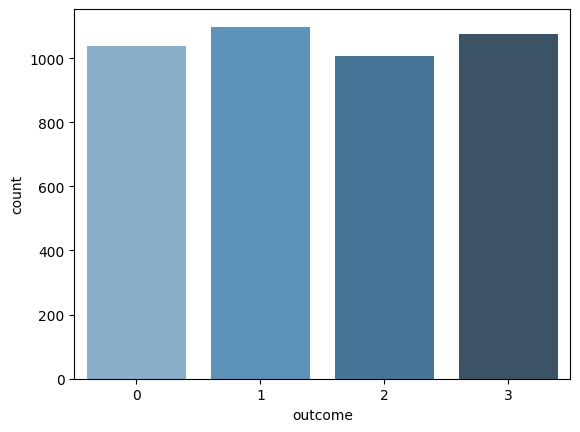

In [11]:
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')

## Plotting the sample images

It was found that all the image pixels are not between [0-255]. Hence, simply normalizing or dividing the image with 255 lead to problems. Hence, each image was normalized using the Min-Max Scaling method to bring the values in the range [0, 1].

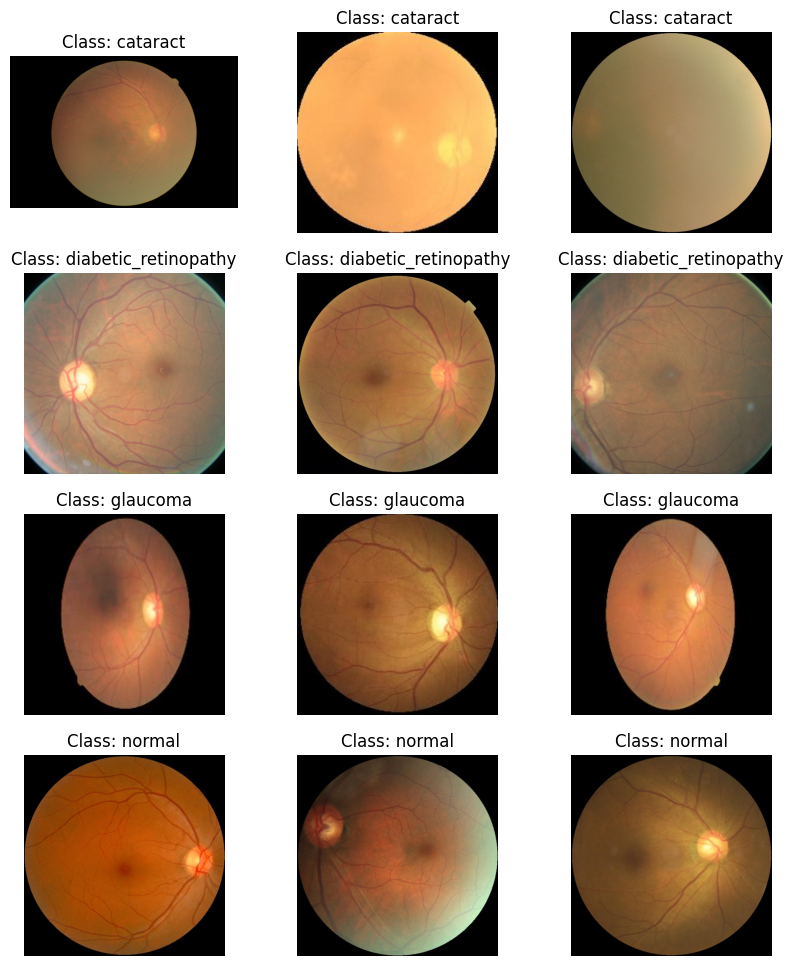

In [12]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1
        
plt.show()

# Building the dataset

1. The dataset was building using `torch.utils.data.Dataset` for efficinet loading of data.
2. For data augmentation, only Random Horizontal and Vertical flip was used. Adding augmentaitons in colors, brightness etc made training difficult, since then 

In [13]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]
        
        img = (img - img.min())/img.max()
        
        if self.transform:
            img = self.transform(img)
            
        return img.to(torch.float32), label

1. 85% of the dataset was used for training while the remaining for validation/testing.
2. Batch Size of 128 was chosen.

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

In [15]:
NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [16]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


# Model Architecture

1. We used the Resnet18 pretrained model for this task.

2. ResNet-18 is composed of multiple residual blocks, which are designed to address the problem of vanishing gradients in deep neural networks. These blocks introduce skip connections, allowing information to bypass several layers and flow directly to deeper layers. This helps in mitigating the degradation problem and enables the network to learn more effectively, even with very deep architectures.

3. We replaced the final layer with two new dense layer. 70% of the resnet18 was freezed while the remaining was kept trianable. The resnet18 block was trained with a lr of 5x10 <sup>-5</sup> while the dense layers with lr = 8x10<sup>-4</sup>. 

![resnet18](https://i.imgur.com/XwcnU5x.png)

In [17]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet50(pretrained = True)
        
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
            
        self.block = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
        
        
    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])
        
        
    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x
            
#  👁️ PyTorch: Eye Disease Classification| 92.7%

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device
        
        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)
        
        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, acc
    
    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)
            
        return loss, acc
    
    def step_fxn(self, loader, step):
        loss, acc = 0, 0
        
        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()
            
        return loss/len(loader), acc/len(loader)
    
    def train(self, epochs):
        
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            
            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)
            
            
            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))
    

In [18]:
trainer = Trainer(train_loader, val_loader, device)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\adity/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:09<00:00, 1.48MB/s]


## Summary of the model

In [19]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

## Training the model

In [20]:
trainer.train(epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.750 acc: 0.690] Val: [loss: 0.527 acc:0.780]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.442 acc: 0.833] Val: [loss: 0.400 acc:0.831]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.319 acc: 0.880] Val: [loss: 0.372 acc:0.831]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.272 acc: 0.896] Val: [loss: 0.334 acc:0.873]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.260 acc: 0.906] Val: [loss: 0.346 acc:0.855]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.216 acc: 0.919] Val: [loss: 0.297 acc:0.890]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.185 acc: 0.930] Val: [loss: 0.306 acc:0.888]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.158 acc: 0.938] Val: [loss: 0.272 acc:0.908]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.129 acc: 0.952] Val: [loss: 0.287 acc:0.901]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.116 acc: 0.959] Val: [loss: 0.297 acc:0.905]


# Plotting Model Results

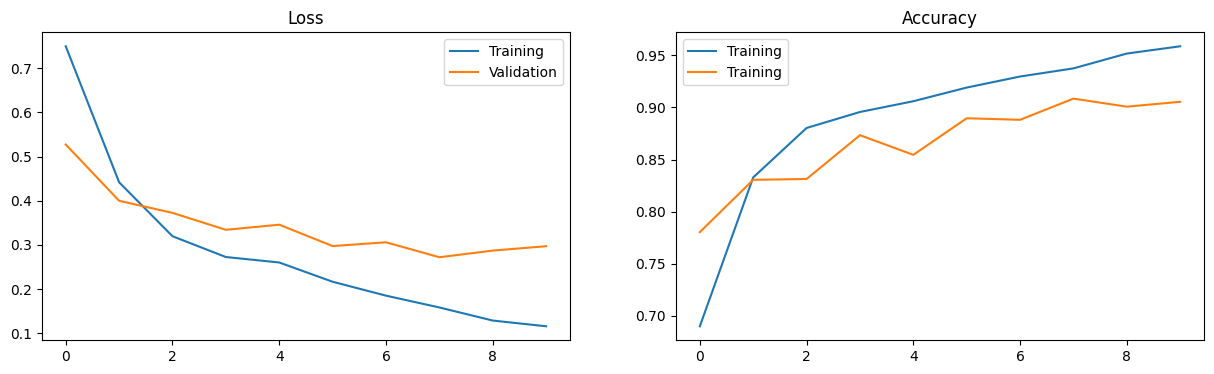

In [21]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()



# Model Predictions

In [22]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)
        
len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

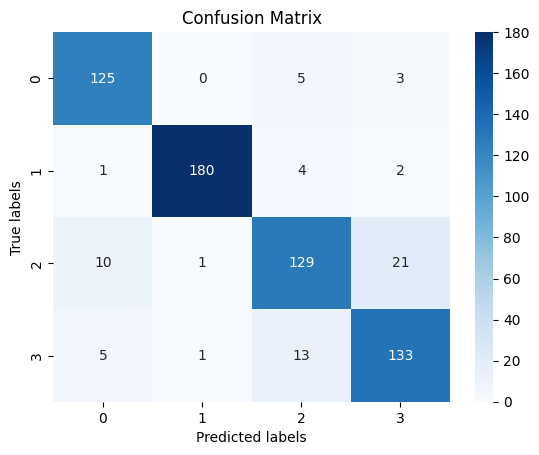

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [24]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.89      0.94      0.91       133
diabetic_retinopathy       0.99      0.96      0.98       187
            glaucoma       0.85      0.80      0.83       161
              normal       0.84      0.88      0.86       152

            accuracy                           0.90       633
           macro avg       0.89      0.89      0.89       633
        weighted avg       0.90      0.90      0.90       633



In [25]:
torch.save(trainer.model.state_dict(), 'model_weights_2.pth')